In [1]:
## Required library importation

%matplotlib widget
import numpy as np
import math
from sympy import *
from scipy.constants import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad, tplquad, dblquad
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
import plotly.graph_objects as go

In [33]:
class hydrogen_atom_WaveFunc:
    """
    Computing the solution for Schrodinger Eq. of two particle (H atom)

    - Input Parameter -
        Radial Distance from the center
        Principal Quantum Number (n = 1, 2, 3, ... )
        Azimuthal Quantum Number (l = 0, 1, 2, 3, ..., n-1)
        Magnatic Number (m_l = -l, -l+1, ..., 0, ..., l-1, l)
        Polar Angle (0 < theta < 180)
        Longtitude Angle (0 < phi < 360)
    
    - return -
        Hydrogen Atom Wavefunction, given parameter (n, l, m_l)
    """
    
    def __init__(self, radial,q_num,sphe_qNum, mag_num,polar_ang,long_ang):
        
        self.radial = radial
        self.q_num = q_num
        self.sphe_qNum = sphe_qNum
        self.mag_num = mag_num
        
        self.polar_ang = polar_ang
        self.long_ang = long_ang

    @staticmethod
    def associated_legendre_poly(x, l, m_l):
        x_sym = symbols('x')
        
        derivative_part = diff((x_sym**2 - 1)**l, x_sym, l + m_l)
    
        constant_portion = Pow(1 - x_sym**2, m_l / 2) / (Pow(2, l) * math.factorial(l))
    
        rod_poly = constant_portion * derivative_part

        
        numerical_input = lambdify(x_sym, rod_poly, 'numpy')

        
        return numerical_input(x)

    
    @staticmethod
    def lag_polyNorm(x, n, l, Z = 1):
    
        rho_value = x * Z * 2 / n 
        
        fractional_component = Pow(rho_value, -(2*l + 1)) * exp(rho_value) / math.factorial(n-l-1)
        
        x_symbol = symbols('r'); differential_component = diff(exp(-x_symbol)*Pow(x_symbol,n+l),x_symbol,n-l-1)
    
        numerical_input = lambdify(x_symbol, differential_component, 'numpy')
    
        return fractional_component * numerical_input(rho_value)
        

    def radial_function(self, Z = 1):
        
        radial_prime = Pow(2 * self.radial * Z / self.q_num , self.sphe_qNum) * np.exp(- self.radial * Z / self.q_num) \
        * self.lag_polyNorm(self.radial, self.q_num, self.sphe_qNum)
        
        def integrand(r):
        
            return Pow(r * Pow(2 * r / self.q_num , self.sphe_qNum) * exp(- r / self.q_num)\
                       * self.lag_polyNorm(r,self.q_num,self.sphe_qNum), 2)
        
        
        norm_Const = Pow(quad(integrand,0,np.inf)[0],-.5)
        
        return norm_Const * radial_prime

    def spherical_harmonics_partially(self):
        
        normalize_part = Pow(-1,self.mag_num) *  Pow(((2 * self.sphe_qNum + 1) * factorial(self.sphe_qNum - np.abs(self.mag_num)))\
                         / 4 / np.pi / factorial(self.sphe_qNum + np.abs(self.mag_num)), 0.5)
    
        polynomial_part = self.associated_legendre_poly(np.cos(self.polar_ang), self.sphe_qNum, self.mag_num)
        
        return normalize_part * polynomial_part
    
    def wavefunction_product(self):
        
        return self.radial_function() * self.spherical_harmonics_partially() #* np.exp(2 * self.mag_num * self.long_ang)

    def probability_density(self):

        return Pow(self.wavefunction_product(),2)


In [133]:
#fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [166]:
##############################################################################################################
## Parameter Input
angular_Qnum = 1                                   # Angular Q Num
mag_Qnum   = 0                                     # Magnetic Q Num
theta = 0                                          # Azimutal Angle 
phi = 0                                            # Plane Angle
a_0 = physical_constants["Bohr radius"][0]         # Bohr Radius
upper_limitRadius = 40                             # Upper Limitation Range for Radius
# radius_range = np.arange(0,upper_limitRadius,.5) # Radius Range
radius_range = np.arange(0,upper_limitRadius+.5,.5) # Radius Range

##############################################################################################################
## matplotlib plotting

fig,ax = plt.subplots(1,1,figsize=(7,6))
# for princ_QNum in np.arange(2,5):
princ_QNum = 2
for _o,theta in enumerate(np.arange(0,91,10)):
    collect_probDens = []
    
    for radi in radius_range:
        prob_dens = hydrogen_atom_WaveFunc(radi,princ_QNum,angular_Qnum,mag_Qnum, theta, phi).probability_density()
        # collect_probDens.append(prob_dens * np.power(radi,2) * 4 * np.pi)
        collect_probDens.append(prob_dens)
    ax.plot(
        radius_range,
        collect_probDens,
        color=colorFader('red','blue',_o/np.arange(0,91,10).shape[0]),
        alpha=.9,
        # label=f"n = {princ_QNum}",
        linewidth=3
    )

ax.set_yticks([]) # Setting no ticks on y axis
# ax.set_xticks([radi_pos for radi_pos in np.arange(.0, ,.5)], [f"{radi_pos:.1f}" for radi_pos in np.arange(.0, 10,.5)])

ax.set_xlim([-.001,upper_limitRadius])

# Axis Label
ax.set_xlabel("Radius ($\\times a_{0}$) / r ",fontsize=14)
# ax.set_ylabel("Radial Probability / 4$\\pi r^{2}|\\psi(r)|^{2}$",fontsize=14)
ax.set_ylabel("Electron Probability / |\\psi(r)|^{2}$",fontsize=14)

# Tick location (MultipleLocator function)
ax.xaxis.set_major_locator(MultipleLocator(5.0));ax.xaxis.set_minor_locator(MultipleLocator(1.0))

# Tick size for major/minor and its location
ax.tick_params(axis = 'both', direction = 'in', size = 7, width = 2.5,labelsize = 10, which = 'major')
ax.tick_params(axis = 'both', direction = 'in', size = 4.5, width = 2.5,labelsize = 23, which = 'minor')

ax.legend(fontsize=13)
##############################################################################################################
fig.tight_layout()
# PDF Page Setting
pdf = PdfPages("radial_wavefunction_p_wavefunction_orbital.pdf");pdf.savefig(fig);pdf.close()


/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
##############################################################################################################
## Parameter Input

princ_QNum = 3                                     # Principal Q Num
angular_Qnum = 2                                   # Angular Q Num
mag_Qnum   = 1                                     # Magnetic Q Num
a_0 = physical_constants["Bohr radius"][0]         # Bohr Radius
upper_limitRadius = 20                             # Upper Limitation Range for Radius
spacing_num = 40
##############################################################################################################
# Spherical Representation of Atomic Oribital

# Set up the 3D grid
x_range = np.linspace(-upper_limitRadius, upper_limitRadius, spacing_num)
y_range = np.linspace(-upper_limitRadius, upper_limitRadius, spacing_num)
z_range = np.linspace(-upper_limitRadius, upper_limitRadius, spacing_num)
x, y, z = np.meshgrid(x_range, y_range, z_range)

# Convert Cartesian to Spherical Coordinates
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / np.where(r == 0, 1e-10, r))
phi = np.arctan2(y, x)

# # The probability density is the magnitude squared of the wavefunction
probability_density = np.zeros((x_range.shape[0], y_range.shape[0],z_range.shape[0]))
for x_ in  np.arange(x_range.shape[0]):
    for y_ in  np.arange(y_range.shape[0]):
        for z_ in  np.arange(z_range.shape[0]):
            radii = r[x_][y_][z_];theta_ = theta[x_][y_][z_]; phi_ = phi[x_][y_][z_]
            prob_ = hydrogen_atom_WaveFunc(radii,princ_QNum, angular_Qnum, mag_Qnum, theta_, phi_).probability_density()
            probability_density[x_][y_][z_] = prob_

isovalue = 1e-4

fig = go.Figure(data=go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=probability_density.flatten(),
    isomin=0,
    isomax=isovalue,
    colorscale='rdbu',
    surface_count=1,
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
    title=f'Isosurface of the |Ψ<sub>{princ_QNum}{angular_Qnum}{mag_Qnum}</sub>|² Orbital',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    autosize=False,
    width=800,
    height=800
)

fig.write_html(f"psi_n{princ_QNum}_l{angular_Qnum}_ml{mag_Qnum}.html")

In [357]:
###################################################################################################################################################
### Angular Wavefunction

def rodigrue_polyNorm(x, l,m_l):
    x_sym = symbols('x')
    
    deriviate_function = diff((x_sym**2 - 1)**l,x_sym,l+m_l)
    
    constant_portion = Pow(-1,m_l) / np.power(2,l) / math.factorial(l) * Pow(1 - x**2,np.abs(m_l / 2))

    # rod_Poly = constant_portion * deriviate_function
    
    numerical_input = lambdify(x_sym, constant_portion * deriviate_function, 'numpy')
    
    return  numerical_input(x)

def associated_legendre_poly(x, l, m_l):
    x_sym = symbols('x')

    derivative_part = diff((x_sym**2 - 1)**l, x_sym, l + m_l)

    constant_portion = Pow(1 - x_sym**2, m_l / 2) / (Pow(2, l) * math.factorial(l))

    rod_poly = constant_portion * derivative_part

    numerical_input = lambdify(x_sym, rod_poly, 'numpy')

    return numerical_input(x)

def spherical_harmonics_partially(n,l,m_l,theta):
    
    normalize_part = Pow(-1,m_l) *  Pow(((2 * l + 1) * factorial(l - m_l)) / 4 / np.pi / factorial(l + m_l), 0.5)

    # polynomial_part = rodigrue_polyNorm(cos(theta), l, m_l)
    polynomial_part = associated_legendre_poly(cos(theta), l, m_l)
    
    return normalize_part * polynomial_part
###################################################################################################################################################
## Radial Wavefunction
def lag_polyNorm(x, n, l, Z = 1):

    rho_value = x * Z * 2 / n 
    
    fractional_component = Pow(rho_value, -(2*l + 1)) * exp(rho_value) / math.factorial(n-l-1)
    
    x_symbol = symbols('r'); differential_component = diff(exp(-x_symbol)*Pow(x_symbol,n+l),x_symbol,n-l-1)

    numerical_input = lambdify(x_symbol, differential_component, 'numpy')

    return fractional_component * numerical_input(rho_value)

def radial_function(r,n,l, Z = 1):
    
    radial_prime = Pow(2 * r * Z / n , l) * np.exp(- r * Z / n) \
    * lag_polyNorm(r, n, l)
    
    def integrand(r):
    
        return Pow(r * Pow(2 * r / n , l) * exp(- r / n) * lag_polyNorm(r,n,l), 2)
    
    norm_Const = Pow(quad(integrand,0,np.inf)[0],-.5)
    
    return norm_Const * radial_prime
###################################################################################################################################################

In [373]:
## Integration of the probability ##
n = 1
l = 0
m_l = 0

def radial_component(r):
    return Pow(radial_function(r,n,l),2) * Pow(r,2)
def angular_component(phi, theta): 
    return np.sin(theta) * Pow(spherical_harmonics_partially(n,l,m_l,theta),2)

print(quad(radial_component,0,np.inf)[0] * dblquad(angular_component, 0, np.pi,lambda theta: 0.0, lambda theta: 2*np.pi)[0])

0.9999999999999998


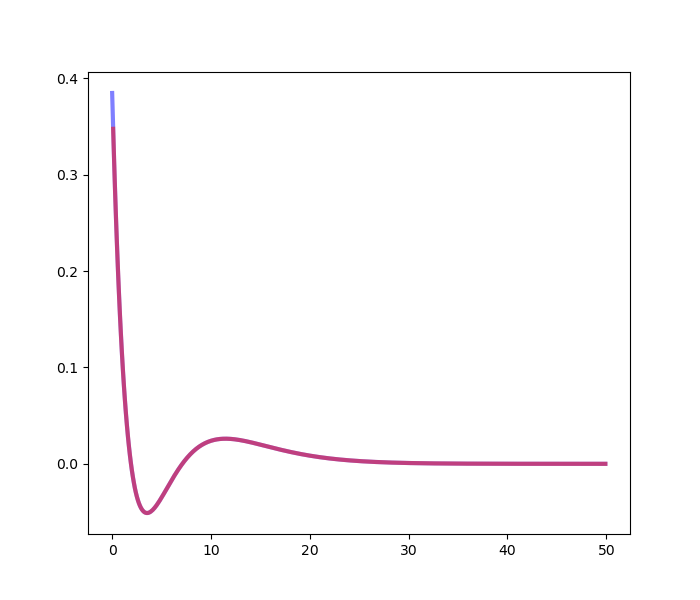

In [17]:
## Plotting Radial Wavefunction
fig,ax = plt.subplots(1,1,figsize=(7,6))

a_0 = physical_constants["Bohr radius"][0]

# def lag_polyNorm(x, n, l):

#     return sum([(np.power(-1, k) * math.factorial(l+n) / math.factorial(n-l-1-k)
#                 / math.factorial(2*l+1+k) * np.power(2*x/n ,k)) for k in np.arange(n-l)])

# def test_radial_Fun(x,n,l):
    
#     radial_prime = np.power(2 * x / n , l) * np.exp(- x / n) * lag_polyNorm(x, n,l)
    
#     def integrand(r):
    
#         return np.power(r * np.power(2 * r / n , l) * np.exp(- r / n) * lag_polyNorm(r, n, l), 2)
        
#     norm_Const = np.power(quad(integrand,0,np.inf)[0],-.5)
    
#     return norm_Const * radial_prime

radial_function,created_function = [], []; 
for radi in np.arange(0,50,1e-1):
    
    created_function.append(hydrogen_atom_WaveFunc(radi,3,0,0,0,0).radial_function())
    
    rho_value = 2 * radi / 3     
    radial_function.append(1/9 / np.sqrt(3) * (6-6*rho_value + rho_value ** 2) * np.exp(-rho_value/2))
    
ax.plot(
    np.arange(0,50,1e-1),
    radial_function,
    color='blue',
    alpha=.5,
    # label=f"n = {princ_QNum}",
    linewidth=3
)

ax.plot(
    np.arange(0,50,1e-1),
    created_function,
    color='red',
    alpha=.5,
    # label=f"n = {princ_QNum}",
    linewidth=3
)

# ax.legend()
plt.show()